In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo

# Ejemplo de multiclass

In [2]:
import os.path
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/fnn_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/MNIST_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/draw_nn.py

# MLP in MNIST database of handwritten digits <a class="tocSkip">
- MNIST (Modified National Institute of Standards and Technology database) 
- MPL (Multi-Layer Perceptron)

# Introducción
## Performance de distintos clasificadores 

Ver classifiers:

https://en.wikipedia.org/wiki/MNIST_database

## El MNIST dataset

- Surge de mezclar el NIST original (Test set y Train set eran de fuentes diferentes)
- Mas de 20 años de publicaciones al respecto
- Muy investigado y mucha documentación
- 60.000 imagenes en training y 10.000 en testing
- Todas las imagenes del mismo tamaño 28x28
- Ya preprocesadas
- En su publicación original en 2002 se utilizó SVM (Support Vector Machine) con una exactitud de 0.8

## Video recomendado:
[Tensorflow and deep learning, without a PhD](https://www.youtube.com/watch?v=vq2nnJ4g6N0)

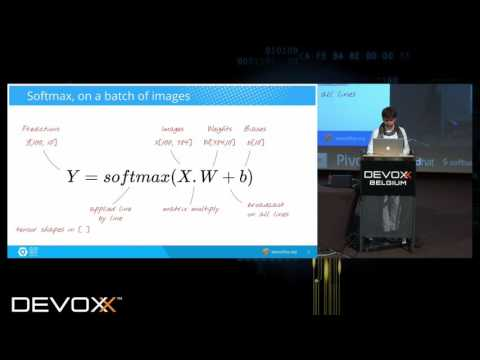

In [3]:
YouTubeVideo('vq2nnJ4g6N0')

# Importar y analizar dataset

In [4]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
import draw_nn

Using TensorFlow backend.


## Importo el dataset

In [5]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

In [6]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


## Grafico los 100 primeros dígitos

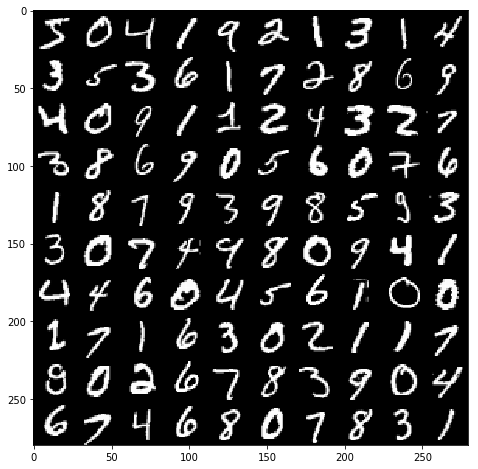

In [7]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

## Vizualizo un dígito en escala de grises

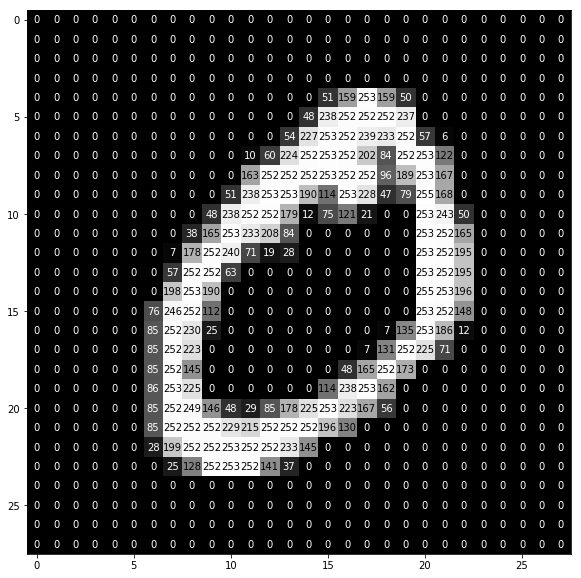

In [8]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[1], ax)
plt.show()

# Regresión logística multinomial

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

## Acomodo entrada

In [10]:
x_train_flattened = x_train.reshape(-1,784)
x_test_flattened = x_test.reshape(-1,784)

## Entreno clasificador

In [11]:
clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05)
clf_logistic.fit(x_train_flattened, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.05, verbose=0,
                   warm_start=False)

## Imprimo resultados

In [12]:
train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
print(train_score_logistic, test_score_logistic)

0.9299583333333333 0.9249


# Red Neuronal de 1 Capa (Regresión Logística)

## Diagrama

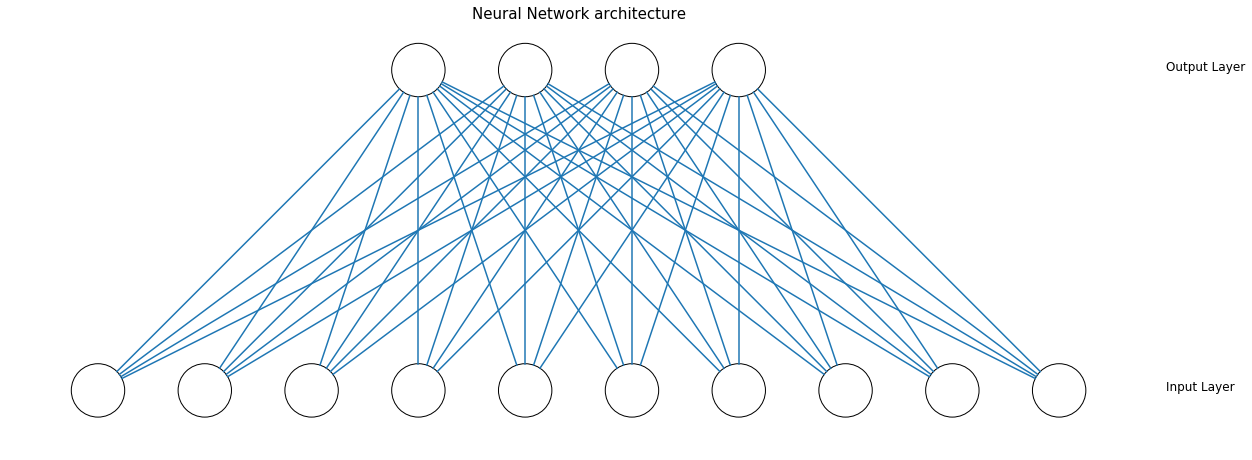

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [13]:
network = draw_nn.DrawNN( [10,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

In [48]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K

In [15]:
x_train.shape[1:]

(28, 28)

## Acomodo Salida: one-hot encoding

In [16]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[:5])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Definimos el modelo

In [17]:
x_train.shape

(48000, 28, 28)

In [18]:
output_size = 10

# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:])) # Esta capa es opcional, se podria haber hecho el flatten antes
model_single_layer.add(Dense(output_size, kernel_initializer='zeros', name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compilamos el modelo
lr suele ser proporcional al mini-bath size. Es decir que si funciona con un lr y aumento el bs, deberia aumentar proporcionalmente el lr

In [19]:
# Compilo el modelo
lr = 0.00001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
#lr = 0.00000001
#lr = 0.01
SGD = optimizers.SGD(lr=lr, decay=1e-3)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

## Preguntas y explicación de parametros

- ¿Por que tiene esa cantidad de parametros?

Capas ([Core Layers](https://keras.io/layers/core/)):
- Dense
- Flatten
- Activation

Parámetros:
- Learning Rate (lr)
- Funciones de activación ([Activations](https://keras.io/activations/)): Sigmoid, Relu, [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- Optimizers: [Keras](https://keras.io/optimizers/), [Articulo interesante](http://ruder.io/optimizing-gradient-descent/)
- Costo ([losses](https://keras.io/losses/))
- [Initializers](https://keras.io/initializers/)

## Exactitud del modelo sin entrenar
**¿Cuanto es de esperar?**

In [20]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.302585363006592
accuracy:  0.098


## Defino Callbacks
(No son estrictamente necesarias)

In [22]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='log_reg.mnist.hdf5', verbose=1, save_best_only=True)
tbCB = TensorBoard(log_dir='./log_logistic_reg', histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=False, write_images=False, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

## Entreno el modelo

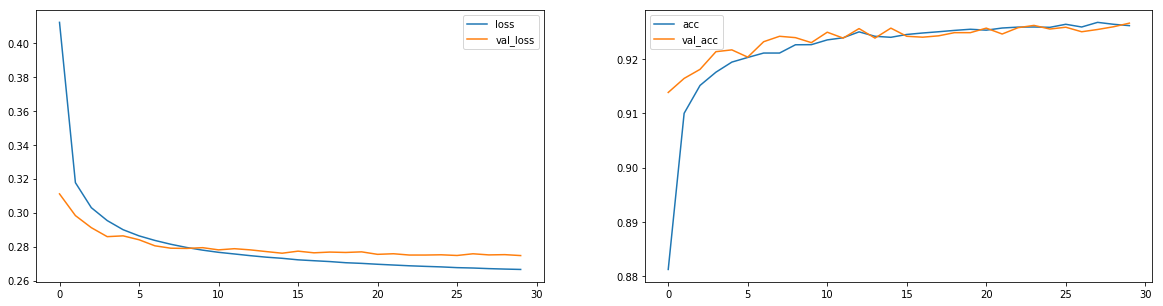


Epoch 00030: val_loss improved from 0.27476 to 0.27471, saving model to log_reg.mnist.hdf5


In [23]:
batch_size = 1000
batch_size = 100
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=30, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer, tbCB],
                      )

**¿Por que val_loss y val_acc es menos ruidosa que loss y val?**

## Exactitud del modelo despues de entrenar

In [24]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.2764814529925585
accuracy:  0.9234


## Analisis de los pesos

(784, 10)
[-1.8327617e-05  1.6772996e-05  1.2150843e-05 -1.7391219e-05
  3.0414492e-06  9.7511780e-05 -6.5465324e-06  3.5679095e-05
 -1.0378233e-04 -1.9107971e-05]


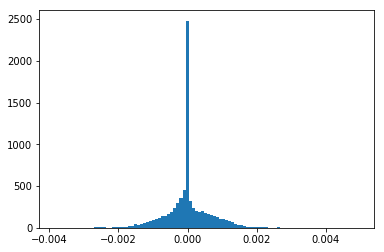

In [25]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)
plt.hist(weights.flatten(), 100)
plt.show()

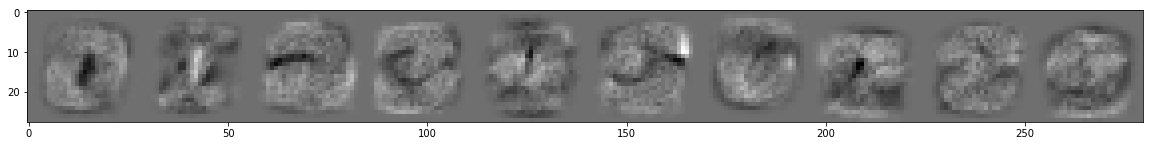

In [26]:
plt.figure(figsize=(20,20))
concatenated_weights = weights[:,0].reshape(28,28)
for wei in weights.T[1:10]:
    concatenated_weights = np.concatenate((concatenated_weights, wei.reshape(28,28)),axis=1 )
plt.imshow(concatenated_weights, cmap='gray')
plt.show()

## Analisis de dígitos errados

In [27]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [28]:
def get_sorted_errors(model):
    losses = []
    for i in range(len(x_test)):
        CE_loss = model.evaluate(x_test[i:i+1], y_test_categorical[i:i+1], verbose=0)[0]
        losses.append(CE_loss)
    predictions = model.predict(x_test)
    predicted_numbers = predictions.argmax(axis=1)
    sorted_loss_indexes = np.argsort(losses)[::-1]
    return predictions, predicted_numbers, sorted_loss_indexes

In [29]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model_single_layer)
print(predictions[:2])
print(predicted_numbers[:2])

[[1.8289666e-05 1.4776566e-10 4.0421939e-05 4.5734136e-03 5.8152608e-07
  7.0091769e-06 1.2995710e-09 9.9483079e-01 4.2806398e-05 4.8667696e-04]
 [7.9955341e-04 6.3074713e-06 9.8554206e-01 1.1209972e-03 3.2333348e-12
  2.7812435e-03 8.7423287e-03 1.7816452e-14 1.0074110e-03 1.3951100e-10]]
[7 2]


[(2, 7), (9, 2), (1, 5), (2, 6), (1, 2), (7, 2), (2, 4), (2, 4), (1, 3), (2, 7), (4, 0), (7, 2), (9, 0), (2, 4), (3, 8), (8, 4), (7, 1), (3, 9), (9, 0), (2, 7), (7, 8), (5, 8), (9, 0), (2, 6), (2, 8), (7, 2), (9, 5), (5, 6), (5, 0), (9, 3), (7, 1), (1, 2), (6, 5), (5, 0), (7, 2), (5, 8), (8, 7), (5, 6), (6, 0), (2, 8), (2, 9), (3, 7), (7, 2), (7, 1), (9, 0), (8, 4), (2, 6), (0, 7), (2, 8), (8, 3), (2, 3), (7, 3), (2, 4), (7, 2), (6, 1), (8, 4), (5, 1), (0, 3), (5, 6), (3, 6), (5, 2), (3, 8), (7, 2), (6, 0), (2, 0), (3, 5), (7, 8), (8, 0), (7, 2), (2, 6), (5, 4), (6, 0), (7, 2), (5, 4), (5, 6), (7, 4), (8, 5), (2, 3), (8, 6), (4, 2), (4, 2), (7, 9), (0, 5), (9, 7), (9, 3), (5, 2), (3, 5), (5, 9), (4, 8), (2, 9), (7, 3), (7, 2), (6, 2), (6, 4), (5, 8), (7, 2), (5, 9), (7, 9), (3, 9), (3, 2)]


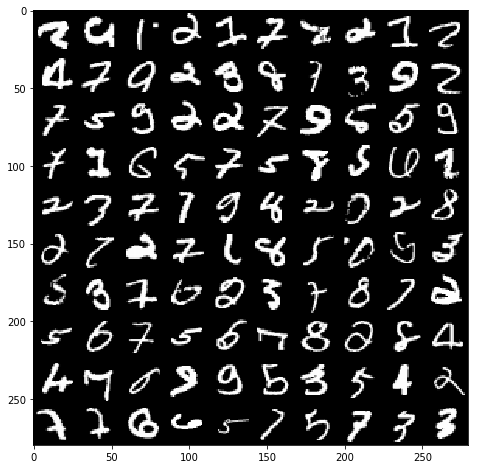

In [30]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

## Cargo pesos guardados
Los pesos fueron guardados con la clase ModelCheckpoint. Vamos a recuperarlos

In [31]:
# Cargo los valores del modelo
model_single_layer.load_weights('log_reg.mnist.hdf5')
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.2764814529925585
accuracy:  0.9234


# Red Neuronal de 2 capas

## Diagrama

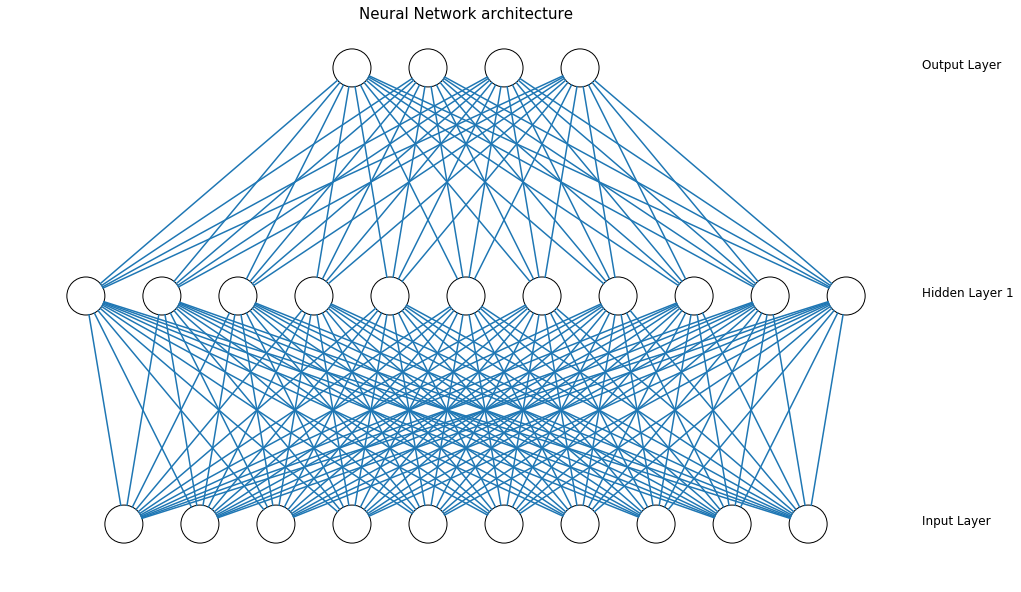

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [32]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

## Definición y compilación del modelo

In [49]:
def two_layer_model(lr=0.000001, decay=0):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='zeros', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
K.clear_session()
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


## Calculo de la cantidad de parámetros
**¿de donde sale la cantidad de parámetros?**

In [50]:
first_layer = 784*800+800
print(first_layer)
last_layer = 800*10 + 10
print(last_layer)
print(first_layer+last_layer)

628000
8010
636010


## Evaluación antes de entrenar

In [51]:
score_two_layers = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])

loss:  2.5651834690093995
accuracy:  0.1028


## Entrenamientos

### Learning rate = 0.01

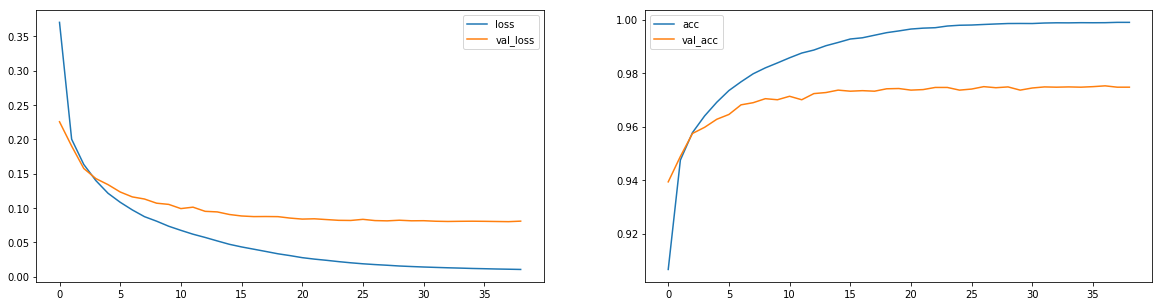


Epoch 00039: val_acc did not improve from 0.97530
Epoch 40/50
  700/48000 [..............................] - ETA: 9s - loss: 0.0181 - acc: 0.9957 

KeyboardInterrupt: 

In [52]:
tbCB2 = TensorBoard(log_dir='./log_one-hidden', histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=False, write_images=False, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='one-hidden.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')

model_two_layers = two_layer_model(lr=0.01) # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer, tbCB2])

In [ ]:
model_two_layers.evaluate(x_train, y_train_categorical)

In [ ]:
model_two_layers.evaluate(x_test, y_test_categorical)

In [39]:
model_two_layers.load_weights('one-hidden.mnist.hdf5')
model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 14us/step


[0.08613288357118144, 0.9731]

(784, 800)
(800,)


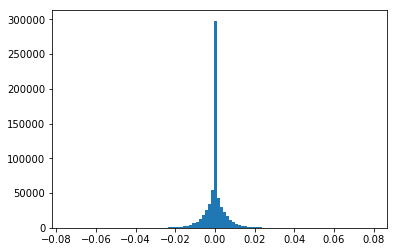

In [42]:
weights = model_two_layers.get_weights()[0]
biases = model_two_layers.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

# Red Neuronal de 5 capas

## Activation: Relus
### Definición y compilación del modelo

In [89]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [90]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='five-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

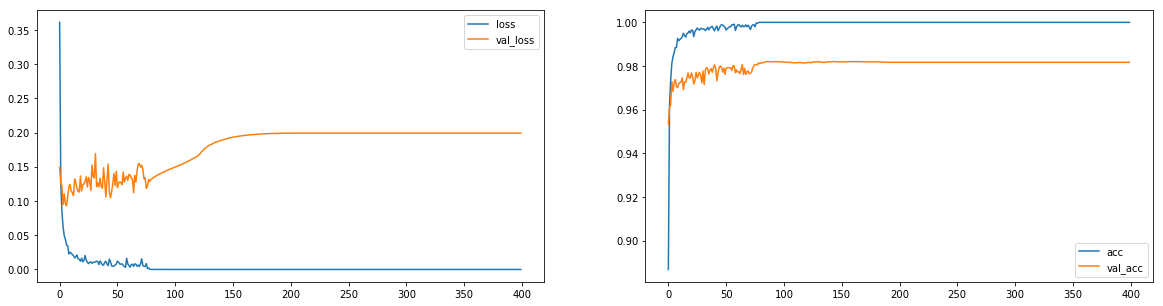


Epoch 00400: val_acc did not improve from 0.98200


In [91]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=400, batch_size=256, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [92]:
model.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 21us/step


[1.1920930376163597e-07, 1.0]

In [93]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 21us/step


[0.1990074875236442, 0.9817]

In [94]:
model.load_weights('five-layer.mnist.hdf5')

In [95]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 23us/step


[0.1381119653036276, 0.982]

(784, 200)
(200,)


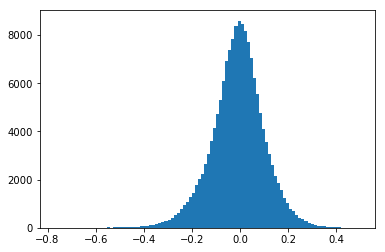

In [96]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

### Resultados

In [97]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model)

[(4, 8), (4, 6), (9, 1), (7, 2), (2, 4), (5, 0), (7, 2), (4, 6), (9, 1), (5, 8), (8, 7), (4, 6), (3, 9), (6, 4), (6, 1), (2, 8), (2, 0), (2, 7), (9, 8), (5, 6), (3, 7), (3, 2), (9, 4), (8, 4), (2, 7), (4, 9), (5, 3), (2, 8), (3, 8), (4, 9), (6, 3), (4, 9), (7, 3), (6, 4), (7, 2), (4, 9), (8, 2), (9, 3), (5, 4), (1, 6), (4, 2), (2, 8), (6, 5), (1, 2), (5, 3), (3, 9), (4, 7), (2, 8), (6, 0), (2, 4), (2, 0), (5, 6), (9, 5), (8, 5), (8, 0), (7, 1), (3, 5), (2, 3), (3, 7), (0, 6), (4, 7), (0, 6), (8, 9), (8, 4), (7, 1), (0, 1), (5, 3), (4, 6), (9, 5), (0, 9), (8, 3), (0, 8), (6, 5), (9, 0), (8, 0), (6, 5), (8, 9), (7, 1), (7, 1), (9, 5), (5, 3), (8, 9), (9, 3), (4, 8), (2, 3), (7, 0), (7, 2), (8, 3), (5, 9), (2, 7), (2, 8), (8, 5), (3, 9), (7, 4), (3, 8), (6, 1), (3, 5), (7, 2), (8, 7), (8, 5)]


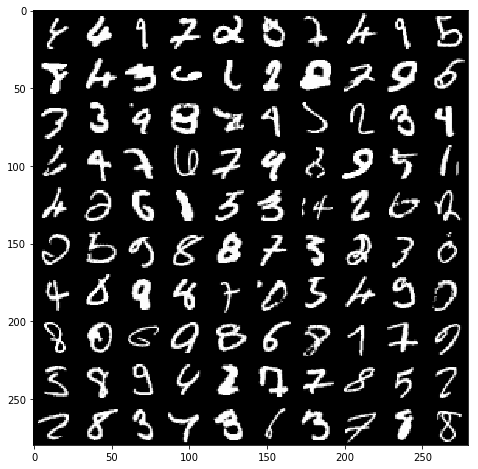

In [98]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

# Representación de los dígitos a la entrada de la Softmax

## Activation: Relus
### Definición y compilación del modelo

In [197]:
output_size = 10
model_plane = Sequential()
model_plane.add(Flatten(input_shape=x_train.shape[1:]))
model_plane.add(Dense(200, activation='relu',  name='middle1'))
model_plane.add(Dense(2, activation='relu', name='middle2'))
model_plane.add(Dense(output_size, activation='softmax', kernel_initializer=initializer, name='salida'))
model_plane.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 2)                 402       
_________________________________________________________________
salida (Dense)               (None, 10)                30        
Total params: 157,432
Trainable params: 157,432
Non-trainable params: 0
_________________________________________________________________


In [198]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='three-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
model_plane.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

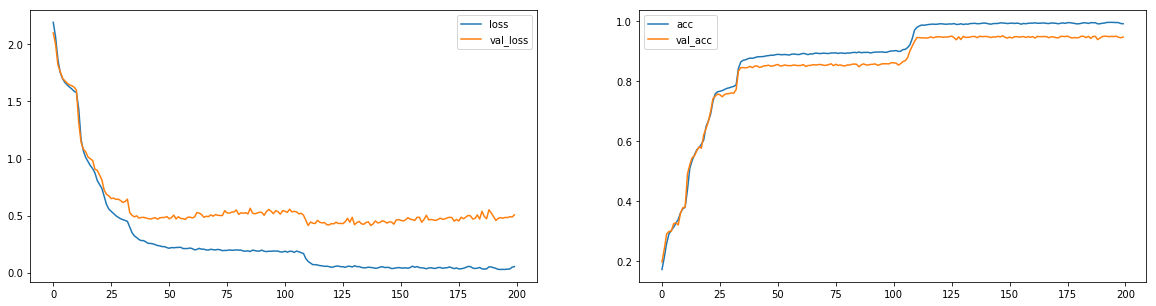


Epoch 00200: val_acc did not improve from 0.95190


In [199]:
model_plane.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=128, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [256]:
model_plane.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 27us/step


[0.03928347856283654, 0.9942291666666667]

In [257]:
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 26us/step


[0.5070825484927743, 0.9476]

In [266]:
# model_plane.load_weights('three-layer.mnist.hdf5')

In [267]:
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 39us/step


[0.5070825484927743, 0.9476]

## Me quedo con el modelo hasta la anteúltima capa

In [301]:
from keras.models import Model

In [269]:
model_trunc = Model(model_plane.input, model_plane.layers[-2].output)

In [270]:
model_trunc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34_input (InputLayer (None, 28, 28)            0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


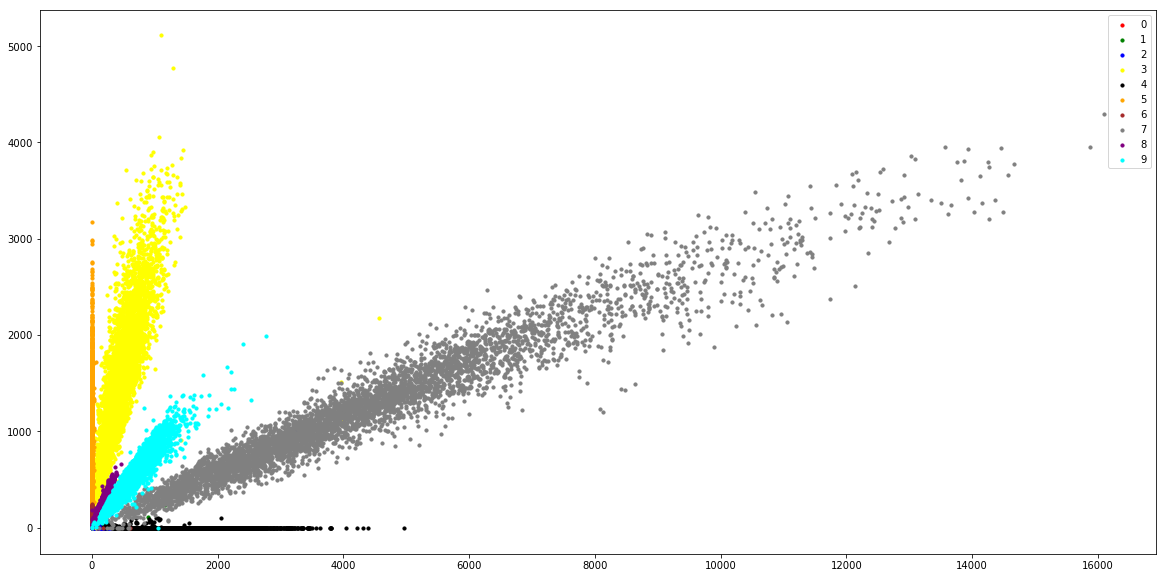

In [275]:
predictions = model_trunc.predict(x_train)
plt.figure(figsize=(20,10))
for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
    plt.scatter(predictions[y_train == i, 0], predictions[y_train == i, 1], c=c, s=10, label=str(i))
plt.legend()

In [302]:
from keras.layers.advanced_activations import LeakyReLU
output_size = 10
model_plane_2 = Sequential()
model_plane_2.add(Flatten(input_shape=x_train.shape[1:]))
model_plane_2.add(Dense(200, name='middle1'))
model_plane_2.add(LeakyReLU())
model_plane_2.add(Dense(200,name='middle2'))
model_plane_2.add(LeakyReLU())
model_plane_2.add(Dense(2, name='middle3'))
model_plane_2.add(LeakyReLU())
model_plane_2.add(Dense(200, name='middle4'))
model_plane_2.add(LeakyReLU())
model_plane_2.add(Dense(200, name='middle5'))
model_plane_2.add(LeakyReLU())
model_plane_2.add(Dense(output_size, activation='softmax', kernel_initializer=initializer, name='salida'))
model_plane_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_44 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
middle2 (Dense)              (None, 200)               40200     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
middle3 (Dense)              (None, 2)                 402       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2)                 0         
__________

In [303]:
adam = optimizers.Adam(lr=0.0001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='four-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
model_plane_2.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

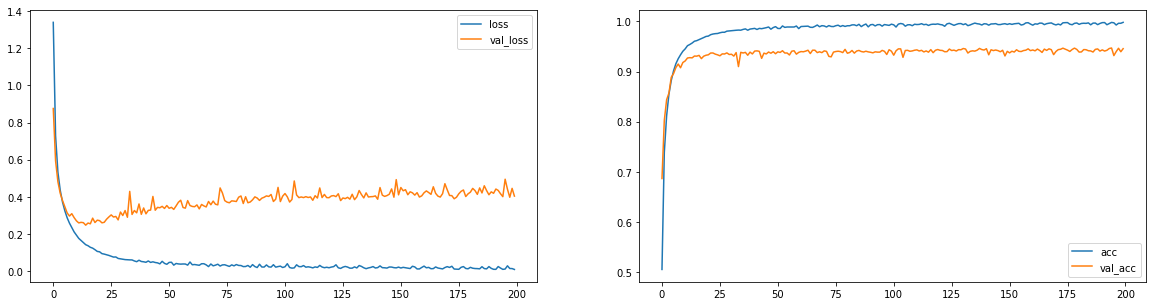


Epoch 00200: val_acc did not improve from 0.94690


In [304]:
model_plane_2.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=128, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [305]:
model_trunc_2 = Model(model_plane_2.input, model_plane_2.layers[-4].output)
model_trunc_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_44_input (InputLayer (None, 28, 28)            0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
middle2 (Dense)              (None, 200)               40200     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
middle3 (Dense)              (None, 2)                 402       
__________

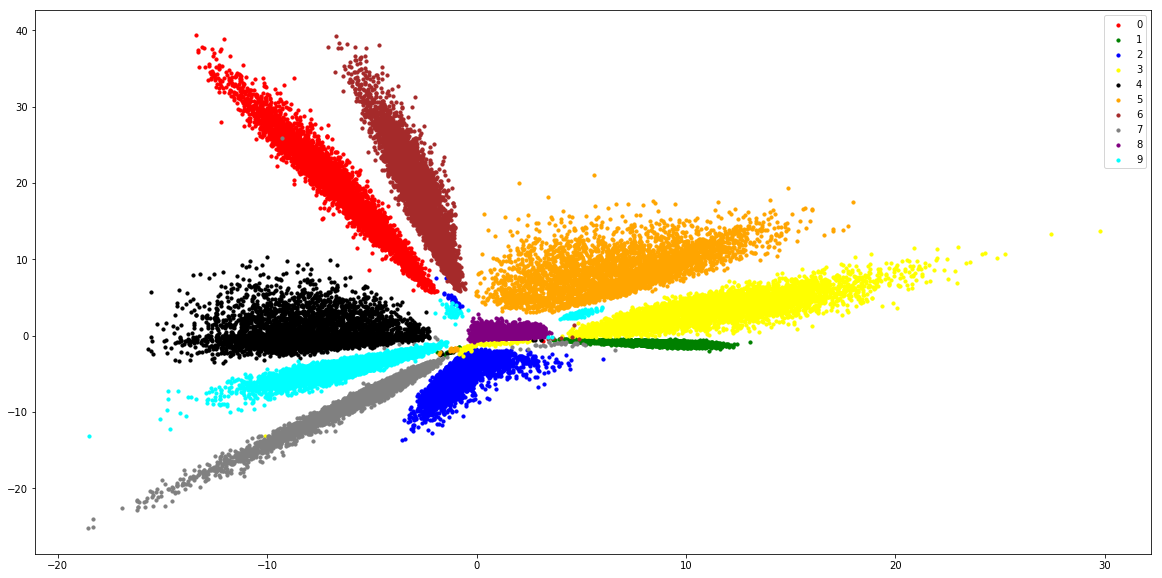

In [306]:
predictions = model_trunc_2.predict(x_train)
plt.figure(figsize=(20,10))
for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
    plt.scatter(predictions[y_train == i, 0], predictions[y_train == i, 1], c=c, s=10, label=str(i))
plt.legend()

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros
- Se pierden las relaciones originales de los pixeles adyacentes (flatten). 